In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

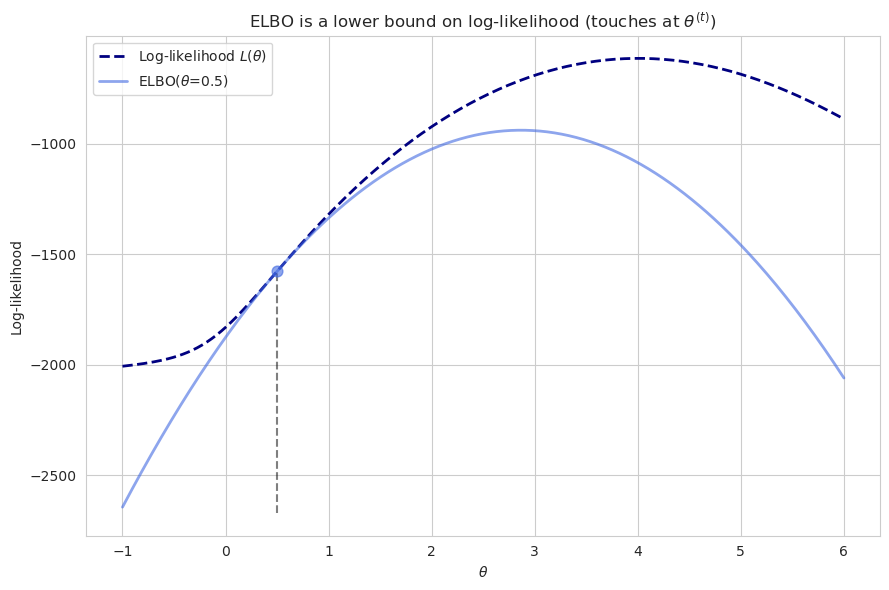

In [ ]:
rng = np.random.default_rng(42)

# --- Synthetic 1D data from a 2-component mixture ---
n = 300
true_means = [0.0, 4.0]
true_stds = [1.0, 1.0]
true_weights = [0.4, 0.6]

z = rng.choice([0,1], size=n, p=true_weights)
X = rng.normal([true_means[i] for i in z],
               [true_stds[i] for i in z])

# --- Helpers: likelihood, responsibilities, Q, entropy, ELBO ---
def log_likelihood(mu):
    w = np.array([0.4, 0.6])
    means = np.array([0.0, mu])
    stds = np.array([1.0, 1.0])
    pdfs = np.vstack([w[k] * (1/np.sqrt(2*np.pi*stds[k]**2)) *
                      np.exp(-0.5*(X - means[k])**2/stds[k]**2)
                      for k in range(2)])
    return np.sum(np.log(np.sum(pdfs, axis=0)))

def responsibilities(mu):
    w = np.array([0.4, 0.6])
    means = np.array([0.0, mu])
    stds = np.array([1.0, 1.0])
    pdfs = np.vstack([w[k] * (1/np.sqrt(2*np.pi*stds[k]**2)) *
                      np.exp(-0.5*(X - means[k])**2/stds[k]**2)
                      for k in range(2)])
    return pdfs / pdfs.sum(axis=0, keepdims=True)

def Q_function(mu, mu_old):
    r = responsibilities(mu_old)
    w = np.array([0.4, 0.6])
    means = np.array([0.0, mu])
    stds = np.array([1.0, 1.0])
    logpdfs = np.vstack([
        -0.5*np.log(2*np.pi*stds[k]**2) - 0.5*(X - means[k])**2/stds[k]**2
        for k in range(2)
    ])
    # include log w_k contribution
    return np.sum(r * (np.log(w[:,None]) + logpdfs))

def entropy_q(mu_old):
    r = responsibilities(mu_old)
    r_clipped = np.clip(r, 1e-16, 1.0)
    return -np.sum(r_clipped * np.log(r_clipped))

def ELBO(mu, mu_old):
    return Q_function(mu, mu_old) + entropy_q(mu_old)

# --- Plot ---
mus = np.linspace(-1, 6, 300)
ll_curve = np.array([log_likelihood(m) for m in mus])

theta_1 = 0.5

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(9,6))
    plt.plot(mus, ll_curve, lw=2, label=r"Log-likelihood $L(\theta)$", linestyle='--', color='navy')
    
    elbo_curve = np.array([ELBO(m, theta_1) for m in mus])
    plt.plot(mus, elbo_curve, lw=2,
                 label=rf"ELBO($\theta$={theta_1:.1f})", alpha=0.6, color='royalblue')
    plt.scatter([theta_1], [log_likelihood(theta_1)],
                    s=60, zorder=5, alpha=0.6, color='royalblue')
    plt.plot([theta_1, theta_1], [min(elbo_curve)*1.01, log_likelihood(theta_1)], 'k--', alpha=0.5)
    plt.title(r"ELBO is a lower bound on log-likelihood (touches at $\theta^{(t)}$)")
    plt.xlabel(r"$\theta$")
    plt.ylabel("Log-likelihood")
    plt.legend()
    plt.tight_layout()
    plt.savefig('../../assets/images/optimization/expectation_maximization_expectation.png', bbox_inches='tight')
    plt.show()

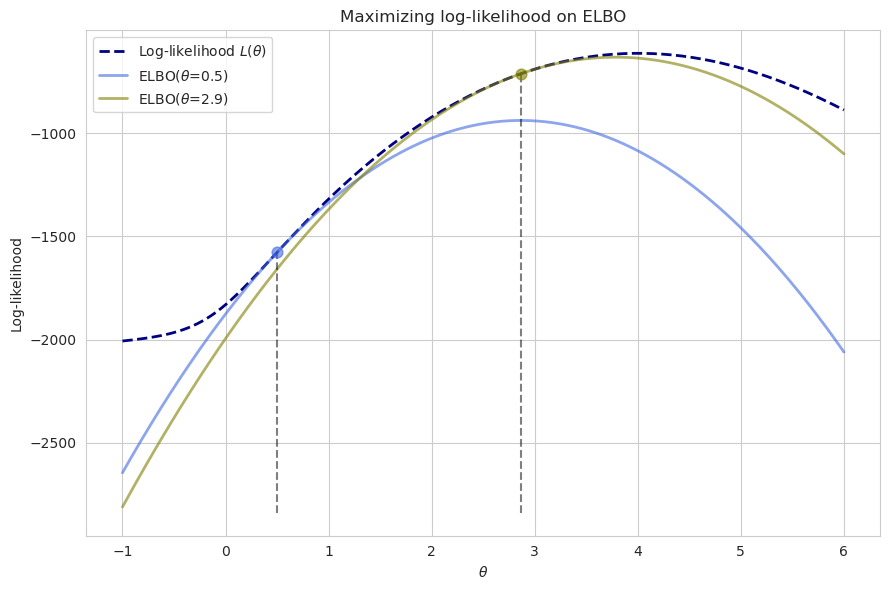

In [77]:
theta_1 = 0.5
elbo_curve1 = np.array([ELBO(m, theta_1) for m in mus])
theta_2 = mus[np.argmax(elbo_curve)]
elbo_curve2 = np.array([ELBO(m, theta_2) for m in mus])

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(9,6))
    plt.plot(mus, ll_curve, lw=2, label=r"Log-likelihood $L(\theta)$", linestyle='--', color='navy')
    
    plt.plot(mus, elbo_curve1, lw=2,
                 label=rf"ELBO($\theta$={theta_1:.1f})", alpha=0.6, color='royalblue')
    plt.plot(mus, elbo_curve2, lw=2,
                 label=rf"ELBO($\theta$={theta_2:.1f})", alpha=0.6, color='olive')
    plt.scatter([theta_1], [log_likelihood(theta_1)],
                    s=60, zorder=5, alpha=0.6, color='royalblue')
    plt.scatter([theta_2], [log_likelihood(theta_2)],
                    s=60, zorder=5, alpha=0.6, color='olive')
    plt.plot([theta_1, theta_1], [min(elbo_curve2)*1.01, log_likelihood(theta_1)], 'k--', alpha=0.5)
    plt.plot([theta_2, theta_2], [min(elbo_curve2)*1.01, log_likelihood(theta_2)], 'k--', alpha=0.5)
    plt.title(r"Maximizing log-likelihood on ELBO")
    plt.xlabel(r"$\theta$")
    plt.ylabel("Log-likelihood")
    plt.legend()
    plt.tight_layout()
    plt.savefig('../../assets/images/optimization/expectation_maximization_maximization.png', bbox_inches='tight')
    plt.show()